In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers
import numpy as np
import datetime
import matplotlib.pyplot as plt

(1, 1000, 3)
(1, 16, 1)


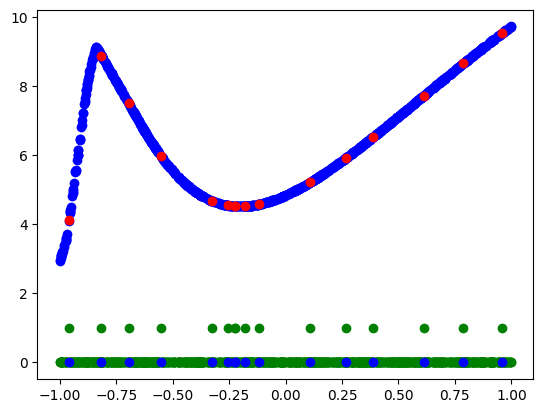

In [49]:
def datagen(tasks, sampl, input_dim=1, output_dim=1, num_queries=1):
    # generate a tensor of shape (tasks, sampl, input_dim + output_dim)
    # using random gaussian sampling for input and then passing through a 4 layer NN with random weights for each task but same weights for each sample
    # using tensorflow tensor operations instead of loops for speed
    x = tf.random.uniform([tasks, sampl, input_dim], minval=-1, maxval=1)
    w1 = tf.random.normal([input_dim, input_dim*16])
    b1 = tf.random.normal([input_dim*16])
    w2 = tf.random.normal([input_dim*16, input_dim*16])
    b2 = tf.random.normal([input_dim*16])
    w3 = tf.random.normal([input_dim*16, input_dim*16])
    b3 = tf.random.normal([input_dim*16])
    w4 = tf.random.normal([input_dim*16, output_dim])
    b4 = tf.random.normal([output_dim])
    y = tf.nn.tanh(tf.matmul(x, w1) + b1)
    y = tf.nn.swish(tf.matmul(y, w2) + b2)
    y = tf.nn.relu(tf.matmul(y, w3) + b3)
    y = tf.matmul(y, w4) + b4
    # the last samples (num_queries) in each sequence are the queries for metalearning, so they're removed from the y tensor and saved as a label tensor which is returned seperately, and then the x+y concattenaed tensor has a dimension added to indicate wether the sample is a query or not
    y_label = y[:, -num_queries:, :]
    y = y[:, :-num_queries, :]
    # the y tensor is padded with zeros to make it the same size as the x tensor
    y = tf.pad(y, [[0, 0], [0, num_queries], [0, 0]])
    # the x and y tensors are concattenaed to make a single tensor of shape (tasks, sampl, input_dim + output_dim)
    x_y = tf.concat([x, y], axis=2)
    # add query indication dimension, with 0s for non-query samples and 1s for query samples
    query_ind = tf.concat([tf.zeros([tasks, sampl-num_queries, 1]), tf.ones([tasks, num_queries, 1])], axis=1)
    x_y = tf.concat([x_y, query_ind], axis=2)

    return x_y, y_label

sample_data, sample_labels = datagen(1, 1000, 1, 1, 16)
print(sample_data.shape)
print(sample_labels.shape)

# plot the function sequence for the first task
plt.plot(sample_data[0, :, 0], sample_data[0, :, 2], 'go')
plt.plot(sample_data[0, :, 0], sample_data[0, :, 1], 'bo')
plt.plot(sample_data[0, -16:, 0], sample_labels[0, :, 0], 'ro')
plt.show()





By default, all Transformers have a key, value, and query size of 32, 8 heads, and 4 layers, and model size of NM = 256. The model size defines the dimensionality of each token, and the MLP between layers scales this size up to a hidden representation of 4 × NM where NM corresponds to the model size.

In [50]:
class BaseAttention(layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = layers.MultiHeadAttention(**kwargs)
    self.layernorm = layers.LayerNormalization()
    self.add = layers.Add()

class GSA(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

class FeedForward(layers.Layer):
  def __init__(self, d_model, dff):
    super().__init__()
    self.seq = models.Sequential([
      layers.Dense(dff, activation='relu'),
      layers.Dense(d_model)
    ])
    self.add = layers.Add()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    return x

class TransformLayer(layers.Layer):
  def __init__(self,*, d_model, num_heads, dff):
    super().__init__()

    self.self_attention = GSA(
        num_heads=num_heads,
        key_dim=d_model)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

class Transformer(models.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff):
    super().__init__()
    self.embedder = layers.Dense(d_model)
    self.layerstack = [TransformLayer(d_model=d_model, num_heads=num_heads, dff=dff) for _ in range(num_layers)]

  def call(self, x):
    x = self.embedder(x)
    for i in range(3):
      for layer in self.layerstack:
        x = layer(x)
    return x[:, -1:, -1]


In [51]:
sampl = 500

mdim = 16
head = 2
mlay = 8
assert mdim % head == 0



(400, 500, 3) (400, 16, 1)
(100, 500, 3) (100, 16, 1)
167


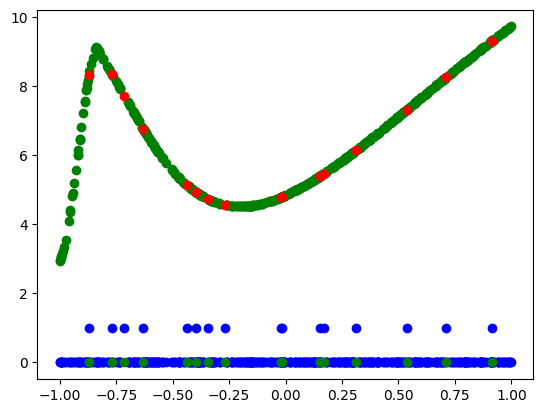

In [52]:
num_train_tasks = 400
train_s, train_l = datagen(num_train_tasks, sampl, num_queries=16)
valid_s, valid_l = datagen(100, sampl, num_queries=16)
print(train_s.shape, train_l.shape)
print(valid_s.shape, valid_l.shape)

# chose a random task to plot
task = np.random.randint(0, num_train_tasks)
print(task)

plt.plot(train_s[0, :, 0], train_s[0, :, 2], 'bo')
plt.plot(train_s[0, :, 0], train_s[0, :, 1], 'go')
plt.plot(train_s[0, -16:, 0], train_l[0, :, 0], 'ro')
plt.show()


In [116]:

%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [117]:

gpicl = Transformer(num_layers=mlay, d_model=mdim, num_heads=head, dff=mdim*4)


In [183]:

class DisplayProgress(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print('Epoch {}/{}'.format(epoch + 1, eps), end='\r')

def loss_fn(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))


opt = optimizers.SGD(learning_rate=0.01)
gpicl.compile(optimizer=opt, loss=loss_fn, metrics=['mae'])

eps = 500

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

#with tf.device('/cpu:0'):
gpicl.fit(train_s, train_l, epochs=eps, batch_size=200, validation_data=(valid_s, valid_l), callbacks=[tensorboard_callback, DisplayProgress()], 
#verbose=0
)
    

Epoch 1/500


2023-03-31 11:50:09.454720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 1.8621 - mae: 0.9646

2023-03-31 11:50:14.423947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 8s 2s/step - loss: 1.8621 - mae: 0.9646 - val_loss: 0.3385 - val_mae: 0.5073
Epoch 2/500
2/2 [==============================] - 2s 1s/step - loss: 2.4482 - mae: 1.1363 - val_loss: 0.3989 - val_mae: 0.5903
Epoch 3/500
2/2 [==============================] - 2s 1s/step - loss: 2.9371 - mae: 1.2463 - val_loss: 0.2445 - val_mae: 0.4257
Epoch 4/500
2/2 [==============================] - 2s 931ms/step - loss: 2.2745 - mae: 0.9804 - val_loss: 0.7135 - val_mae: 0.6477
Epoch 5/500
2/2 [==============================] - 2s 929ms/step - loss: 2.8303 - mae: 1.2484 - val_loss: 0.2883 - val_mae: 0.4459
Epoch 6/500
2/2 [==============================] - 2s 912ms/step - loss: 1.9818 - mae: 0.9997 - val_loss: 0.3598 - val_mae: 0.4778
Epoch 7/500
2/2 [==============================] - 2s 917ms/step - loss: 1.8789 - mae: 0.9697 - val_loss: 0.3805 - val_mae: 0.5367
Epoch 8/500
2/2 [==============================] - 2s 913ms/step - loss: 1.6971 - mae: 0.9126 - val_loss

loss & MAE [0.0754275694489479, 0.20824034512043]
0.05643733
1.9868584
-0.059952535
0.3786287
1/1 [==============================] - 0s 166ms/step
[-3.186183]
1/1 [==============================] - 0s 178ms/step


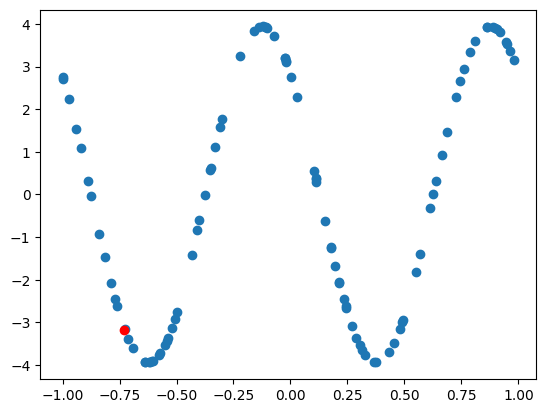

1/1 [==============================] - 0s 326ms/step


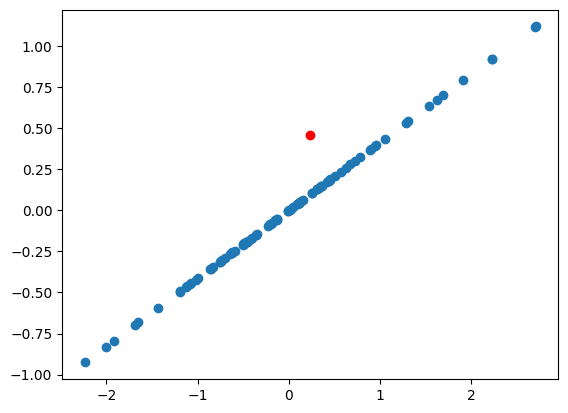

In [194]:
test_s, test_l = datagen(400, sampl)

# get loss on test set
print('loss & MAE', gpicl.evaluate(test_s, test_l, verbose=0))

print(tf.math.reduce_mean(test_l).numpy())
print(tf.math.reduce_std(test_l).numpy())
print(tf.math.reduce_mean(valid_l).numpy())
print(tf.math.reduce_std(valid_l).numpy())

num = np.random.randint(0, 99) 
# plot data points, no lines
plt.plot(test_s[num, :-1, 0], test_s[num, :-1, -1], 'o')
# plot the last 10 points as red points

print(gpicl.predict(test_s[num:num+1, :, :])[0])
plt.plot(test_s[num, -1:, 0], gpicl.predict(test_s[num:num+1, :, :])[0], 'ro')
plt.show()

plt.plot(valid_s[num, :-1, 0], valid_s[num, :-1, -1], 'o')
# plot the last 10 points as red points
plt.plot(valid_s[num, -1:, 0], gpicl.predict(valid_s[num:num+1, :, :])[0], 'ro')
plt.show()

In [189]:
%tensorboard --logdir logs/fit